Brick CNot with random single Qubit gates

In [1]:

# import numpy as np
from qiskit import QuantumCircuit, transpile,Aer,execute
# from qiskit.quantum_info import Kraus, SuperOp
from qiskit_aer import AerSimulator,qasm_simulator
from qiskit.tools.visualization import plot_histogram
from qiskit.quantum_info import DensityMatrix, partial_trace,random_statevector
import random
import numpy as np
import math
import matplotlib.pyplot as plt
from qiskit.visualization import plot_state_city, plot_state_qsphere


In [2]:
import numpy as np
import random
import itertools
import math
import matplotlib.pyplot as plt

from qiskit import QuantumCircuit, transpile,Aer,execute
from qiskit_aer import AerSimulator,qasm_simulator
from qiskit.tools.visualization import plot_histogram
from qiskit.quantum_info import DensityMatrix, partial_trace,random_statevector

def get_cyclic_permutation(permutation):
    '''
    input: arbitary permutation of tokens in complete graph:list
    output: cyclic permutation equivalent of the input:list of lists
    '''
    pi=permutation
    cyclic_permutation=[]
    n=len(pi)
    not_in_cycle=list(range(n))
    while len(not_in_cycle)!=0:
        cycle=[]
        start=not_in_cycle[0]
        current=start
        cycle.append(start)
        not_in_cycle.remove(start)
        final=-1
        while final != start:
            current=permutation[current]
            cycle.append(current)
            if(current in not_in_cycle):
                not_in_cycle.remove(current)
            final=current
        cyclic_permutation.append(cycle)
    cyclic=[]
    for i in cyclic_permutation:
        length=len(i)
        if(length>2):
            cyclic.append(i[:-1])
    return(cyclic)
def Get_Routing_via_matching(cyclic_permutation):
    '''
    input:cyclic permutations: list of lists
    output: 2 step swaps that is equivalent to routing via matching 2 list of list(list of swaps)
    '''
    layer_1=[]
    layer_2=[]
    for cycle in  cyclic_permutation:
        length=len(cycle)
        for j in range(int(len(cycle)/2)):
            layer_1.append([cycle[j],cycle[length-j-1]])
            if(cycle[j+1]!=cycle[length-j-1]):
                layer_2.append([cycle[j+1],cycle[length-j-1]])
    return(layer_1,layer_2)

def old_causaly_cover_nodes(M,i,j):##edges=M
    '''
    input: M=random matching for the complete graph
           i=initial node n>=i,j>=0 int
           j=final node 
    output:boolean:true: iand j are causaly cover
                   false: i and j are not causaly covered
    '''
    path=[i]
    cover=False
    for matching in M: ##if you think about it M is nothing but random matching in our complete graph
        for i in matching:
            current=path[-1]
            if(i[0]==current):
                path.append(i[1])
                if(i[1]==j):
                    cover=True
                break
            elif(i[1]==current):
                path.append(i[0])
                if(i[0]==j):
                    cover=True
                break
        if(cover==True):
            # print("path for causaly cover=",path)
            return cover
    return cover
def causaly_cover_nodes(M,i,j):##edges=M
    '''
    input: M=random matching for the complete graph
           i=initial node n>=i,j>=0 int
           j=final node 
    output:boolean:true: iand j are causaly cover
                   false: i and j are not causaly covered
    '''
    covered_set=[i]
    cover=False
    for matching in M: ##if you think about it M is nothing but random matching in our complete graph
        for k in matching:
            new_covered=[]
            for l in covered_set:
                current=l
                if(k[0]==current):
                    new_covered.append(k[1])
                    if(k[1]==j):
                        cover=True
                        break
                elif(k[1]==current):
                    new_covered.append(k[0])
                    if(k[0]==j):
                        cover=True
                        break
            covered_set=covered_set+new_covered
            if(cover==True):
                # print("path for causaly cover=",path)
                return cover
    return cover

def causaly_cover_graph(M,n):
    nodes=list(range(n))
    ##get all the possible pair combination for nodes:
    permutation=list(itertools.permutations(nodes,2))
    for pairs in permutation:
        is_causaly_cover=causaly_cover_nodes(M,pairs[0],pairs[1])
        if(is_causaly_cover== False):
            return(False,pairs)
    return(True,(-1,-1))
def create_M(pi):
    ''' 
    input: random/ arbitary permutations
    output:return all the matching generated for this permutations using 2 step routing algorithm
    '''
    ##pass all these permutation to get two step routing 
    M=[]
    for i in range(len(pi)):
        cyclic_permutation=get_cyclic_permutation(pi[i])
        O,E=Get_Routing_via_matching(cyclic_permutation)
        M.append(O)
        M.append(E)
    return M
# permutation=random.sample(list(range(5)),5)
# print("permutation=",permutation)
# cyclic_permutation=get_cyclic_permutation(permutation)
# print("cyclic permutations=",cyclic_permutation)
# O,E=Get_Routing_via_matching(cyclic_permutation)
# print("two step routing",O,E)

Brick cnot clifford

In [3]:
def initialize_zero(q,n):
    for i in range(n):
        q.initialize([1,0],i)
    return(q)
def initialize_R_product_state(q,n):
    for i in range(n):
        q.initialize(random_statevector(2).data,i)
    return(q)
def random_clifford(n,qc):
    qubits_list=list(range(n))
    for i in range(500):
        choice=random.choices(['s','h','cnot'])[0]
        qbit=random.choices(qubits_list)[0]
        if choice=='s':
            qc.s(qbit)
        elif choice=='h':
            qc.h(qbit)
        elif choice=='cnot':
            c=qubits_list.copy()
            c.remove(qbit)
            control_bit=random.choices(c)[0]
            pairs=[control_bit,qbit]
            random.shuffle(pairs)
            qc.cnot(pairs[0],pairs[1])
    return qc
def Brick_Cnot_clifford(n,qc,first):
    if(first==True):
        depth=500
    else:
        depth=math.log(n,2)
    layer=0

    while(depth>layer):
        ##layer of even random s and t gate
        for i in range(n):
            choice=random.choices(['s','h'])[0]
            if(choice=='s'):
                qc.s(i)
            elif(choice=='h'):
                qc.h(i)
        layer+=1
        ##layer of even cnot gate 
        for i in range(0,n-1,2):
            qc.cnot(i,i+1)
        layer+=1
        
        ##layer of odd random s and t gate again 
        for i in range(1,n-1,1):
            choice=random.choices(['s','h'])[0]
            if(choice=='s'):
                qc.s(i)
            elif(choice=='h'):
                qc.h(i)
        layer+=1
        
        ##layer of odd cnot    
        for i in range(1,n-2,2):
            qc.cnot(i,i+1)
        layer+=1
    return qc
def random_Cnot_permutation(qc,n):
    pi=[]
    nodes=list(range(n))
    for i in range(int(math.log(n,2))):
        pi.append(list(random.sample(nodes,n)))
    M=create_M(pi)
    ## now add the cnot gate layers according to the matching. 
    for i in M:
        for cnots in i:
            qc.cnot(cnots[0],cnots[1])
        ## after each layer of cnots add random S,H gates to all other qubits
        for i in range(n):
            choice=random.choices(['s','h','i'])[0]
            if choice=='s':
                qc.s(i)
            elif choice=='h':
                qc.h(i)
            elif choice=='i':
                qc.i(i)
    return qc

In [4]:
n=12
qc=QuantumCircuit(n)
##initialization
# qc=initialize_R_product_state(qc,n)
qc=initialize_zero(qc,n)
qc=random_clifford(n,qc)
qc.draw()

┌─────────────────┐     ┌───┐          ┌───┐┌───┐┌───┐               »
 q_0: ┤ Initialize(1,0) ├─────┤ X ├──────────┤ X ├┤ H ├┤ S ├───────────────»
      ├─────────────────┤┌───┐└─┬─┘          └─┬─┘└───┘├───┤┌───┐┌───┐     »
 q_1: ┤ Initialize(1,0) ├┤ S ├──┼──────────────┼───────┤ X ├┤ H ├┤ H ├─────»
      ├─────────────────┤├───┤  │              │  ┌───┐└─┬─┘├───┤└───┘     »
 q_2: ┤ Initialize(1,0) ├┤ S ├──┼──────────────┼──┤ X ├──┼──┤ X ├──────────»
      ├─────────────────┤├───┤  │  ┌───┐┌───┐  │  └─┬─┘  │  └─┬─┘     ┌───┐»
 q_3: ┤ Initialize(1,0) ├┤ S ├──┼──┤ H ├┤ H ├──┼────┼────┼────┼────■──┤ S ├»
      ├─────────────────┤└───┘  │  ├───┤├───┤  │    │    │    │    │  ├───┤»
 q_4: ┤ Initialize(1,0) ├───────┼──┤ X ├┤ S ├──┼────┼────┼────■────┼──┤ S ├»
      ├─────────────────┤┌───┐  │  └─┬─┘└───┘  │    │    │         │  └───┘»
 q_5: ┤ Initialize(1,0) ├┤ H ├──┼────┼─────────┼────┼────┼─────────┼───────»
      ├─────────────────┤├───┤  │    │  ┌───┐  │    │    │         │       »
 q_6: ┤ Initialize(1,0) ├┤ S ├──┼────┼──┤ H ├──┼────┼────┼─────────┼───────»
      ├─────────────────┤└───┘  │    │  ├───┤  │    │    │       ┌─┴─┐┌───┐»
 q_7: ┤ Initialize(1,0) ├───────■────┼──┤ S ├──┼────┼────■───────┤ X ├┤ S ├»
      ├─────────────────┤            │  └───┘  │    │  ┌───┐┌───┐├───┤└───┘»
 q_8: ┤ Initialize(1,0) ├────────────┼─────────■────┼──┤ H ├┤ S ├┤ H ├─────»
      ├─────────────────┤┌───┐┌───┐  │  ┌───┐       │  └───┘└───┘└───┘     »
 q_9: ┤ Initialize(1,0) ├┤ H ├┤ H ├──┼──┤ H ├───────┼──────────────────────»
      ├─────────────────┤└───┘└───┘  │  └───┘       │                      »
q_10: ┤ Initialize(1,0) ├────────────┼──────────────┼──────────────────────»
      ├─────────────────┤            │  ┌───┐       │                      »
q_11: ┤ Initialize(1,0) ├────────────■──┤ S ├───────■──────────────────────»
      └─────────────────┘               └───┘                              »
«                          ┌───┐┌───┐               ┌───┐                    »
« q_0: ──■─────────■───────┤ X ├┤ S ├───────────────┤ X ├────────────────────»
«        │         │       └─┬─┘└───┘               └─┬─┘┌───┐     ┌───┐     »
« q_1: ──┼─────────┼─────────┼──────────────■────■────┼──┤ H ├─────┤ X ├─────»
«        │  ┌───┐  │  ┌───┐  │              │  ┌─┴─┐  │  └───┘┌───┐└─┬─┘┌───┐»
« q_2: ──┼──┤ X ├──┼──┤ S ├──┼──────────────┼──┤ X ├──┼────■──┤ S ├──┼──┤ X ├»
«        │  └─┬─┘  │  ├───┤  │       ┌───┐  │  └───┘  │    │  └───┘  │  └─┬─┘»
« q_3: ──┼────┼────┼──┤ H ├──┼───────┤ X ├──┼─────────┼────┼─────────■────┼──»
«        │    │    │  └───┘  │       └─┬─┘  │         │    │              │  »
« q_4: ──┼────┼────┼─────────┼─────────┼────┼─────────┼────┼────■─────────┼──»
«      ┌─┴─┐  │    │  ┌───┐  │  ┌───┐  │    │         │    │    │         │  »
« q_5: ┤ X ├──┼────┼──┤ H ├──┼──┤ H ├──┼────┼─────────┼────┼────┼─────────■──»
«      └───┘  │    │  └───┘  │  └───┘  │  ┌─┴─┐┌───┐  │    │    │            »
« q_6: ───────┼────┼─────────■─────────┼──┤ X ├┤ H ├──┼────┼────┼────────────»
«             │    │                   │  └───┘└───┘  │    │    │            »
« q_7: ───────┼────┼───────────────────┼──────────────┼────┼────┼────────────»
«             │    │  ┌───┐            │              │  ┌─┴─┐┌─┴─┐          »
« q_8: ───────┼────┼──┤ X ├────────────┼──────────────┼──┤ X ├┤ X ├──────────»
«             │  ┌─┴─┐└─┬─┘┌───┐┌───┐  │  ┌───┐┌───┐  │  ├───┤└───┘          »
« q_9: ───────┼──┤ X ├──■──┤ S ├┤ S ├──┼──┤ H ├┤ S ├──┼──┤ H ├───────────────»
«             │  ├───┤     └───┘└───┘  │  └───┘└───┘  │  └───┘               »
«q_10: ───────■──┤ H ├─────────────────■──────────────┼──────────────────────»
«                └───┘                                │                      »
«q_11: ───────────────────────────────────────────────■──────────────────────»
«                                                                            »
«           ┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐                              »
« q_0: ─────┤ X ├┤ H ├┤ H ├

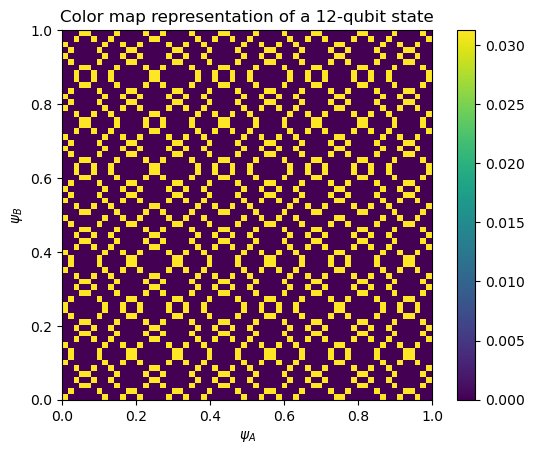

In [5]:
def plot_color_map(qc):
    simulator = Aer.get_backend('statevector_simulator')
    job = execute(qc, simulator)
    result = job.result()
    statevector = result.get_statevector(qc)

    amplitudes = np.abs(statevector)
    amplitudes = amplitudes.reshape((2**int(n/2),2**int(n/2)))

    # Generate the color map image.
    plt.imshow(amplitudes, cmap='viridis', extent=[0, 1, 0, 1])
    plt.colorbar()
    # Define the positions for the five ticks: start, quarter, half, three-quarters, and end
    tick_positions = np.linspace(0, 2**int(n/2), 8, endpoint=True)


    plt.xlabel('$\psi_A$')
    plt.ylabel('$\psi_B$')
    plt.title('Color map representation of a '+str(n)+'-qubit state')
    plt.show()
plot_color_map(qc)

In [6]:
for i in range(n):
    qc.t(i)
qc1=qc.copy()
qc2=qc.copy()
qc1=random_clifford(n,qc1) ####way they did in paper
qc2=random_Cnot_permutation(qc2,n)


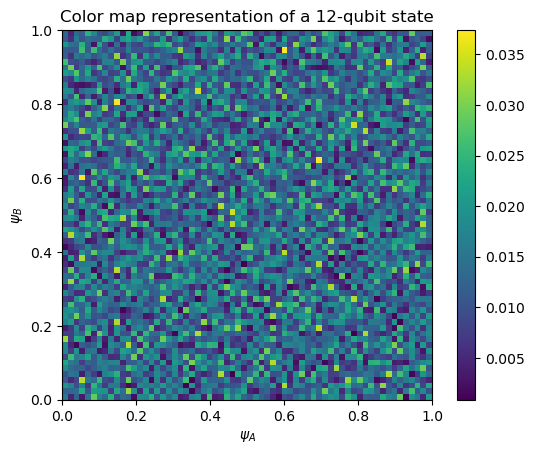

In [7]:

####the way they did in paper
plot_color_map(qc1)
#

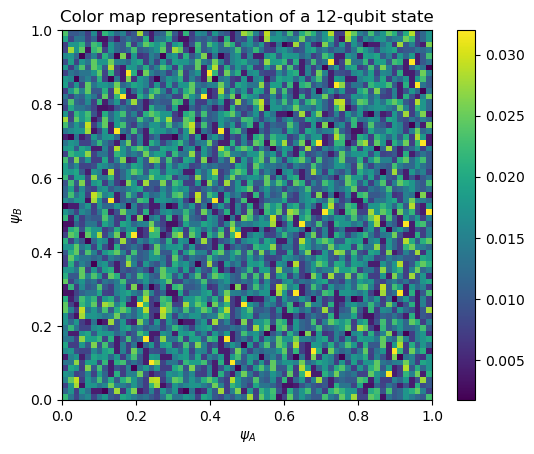

In [8]:
### we generated using permutation layer
plot_color_map(qc2)

In [20]:
rho= DensityMatrix.from_instruction(qc) ##get the state vector of the system
# print(state)
rho_a=partial_trace(state=rho,qargs=list(range(int(n/2),n-1))) ##rho_a is the reduced density matrix for the first a subsystem A(as the paper has divided the whole system into A and B subsystem)
eigenvalues=np.linalg.eigvals(rho_a.data) ##entanglement spectrum is the set of the eigen values of the reduced density matrix
ES=sorted(eigenvalues,reverse=True)
print(ES)
ES_real=[i.real for i in ES ]
print(ES_real)
# lambd=np.sqrt(ES_real)
lambd=ES_real
print(lambd)

In [19]:

r_k_tilda=[]
for i in range(1,len(lambd)-1):
    del_k=lambd[i-1]-lambd[i]
    del_k_P1=lambd[i]-lambd[i+1]
    r_k_tilda.append(min(del_k,del_k_P1)/max(del_k,del_k_P1))
r_mean=np.mean(r_k_tilda)
print(r_mean)

[0.24026643896427757, 0.17981372613645624, 0.16620917245303327, 0.1182925465390606, 0.10566250191997134, 0.08632428494518331, 0.06791747848622319, 0.03551385055565018, 1.305966233134529e-16, 1.3005124409166472e-16, 1.0160579958599864e-16, 9.702013313944911e-17, 9.135972687958225e-17, 7.047758820027237e-17, 5.618920112580994e-17, 4.436595838953249e-17, 3.8134430395144236e-17, 3.562672735449569e-17, -1.5230402392862808e-18, -6.0922205194767745e-18, -1.4404420446687055e-17, -3.134934844038374e-17, -3.526204734406517e-17, -3.786460546730095e-17, -5.85787943526312e-17, -6.356195029278401e-17, -6.676981759938289e-17, -7.997702307767744e-17, -8.56540620850052e-17, -8.58994455296538e-17, -9.875520977374809e-17, -1.029591302358232e-16]
[0.22504455213070168, 0.2839213618222613, 0.26358376405226586, 0.6531131921601421, 0.9518357603990982, 0.5680477043619301, 0.9124222640909262, 1.5356803423316926e-17, 0.01917281418047581, 0.16120916815471492, 0.8101302691049953, 0.2710644894564947, 0.684239641058

{'0000000000': 8.873346532e-05, '0000000001': 0.004141114680833, '0000000010': 0.001101936504546, '0000000011': 0.00071110056128, '0000000100': 0.000923820884495, '0000000101': 0.001141375231207, '0000000110': 0.002868841016117, '0000000111': 0.000345736006173, '0000001000': 0.001750214078513, '0000001001': 5.4707089796e-05, '0000001010': 0.000483626753768, '0000001011': 0.000997228876793, '0000001100': 0.001364515051116, '0000001101': 0.002974621272359, '0000001110': 0.000148234871632, '0000001111': 0.001061071382471, '0000010000': 7.553123005e-06, '0000010001': 0.003016713888683, '0000010010': 0.001128814498627, '0000010011': 0.000906882156542, '0000010100': 0.000937261388168, '0000010101': 0.001620823945704, '0000010110': 0.00252168195778, '0000010111': 0.000248468535188, '0000011000': 0.002717920470533, '0000011001': 0.000130488433876, '0000011010': 0.000356586720924, '0000011011': 0.000349008976565, '0000011100': 0.000788272863474, '0000011101': 0.002195034139218, '0000011110': 0.

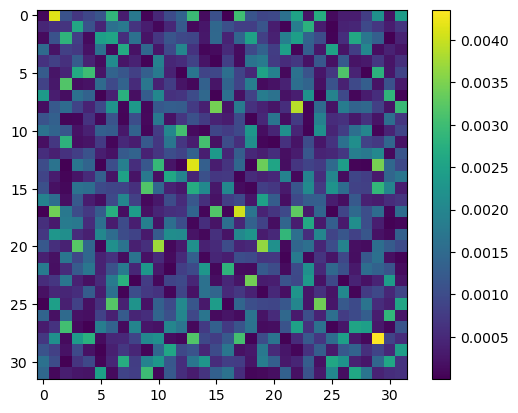

In [512]:
def plot_color_map(qc):
simulator = Aer.get_backend('statevector_simulator')
job = execute(qc, simulator)
result = job.result()
statevector = result.get_statevector(qc)
amplitude=result.get_counts()
print(result.get_counts())
print(list(amplitude.values()))
print(sum(list(amplitude.values())))
print(statevector)
# Create and display the color map
num_states =2** int(qc.num_qubits/2)
wavefunction_matrix = np.reshape(list(amplitude.values()), (num_states, num_states))
plt.imshow(np.abs(wavefunction_matrix), cmap='viridis', interpolation='nearest')
plt.colorbar()

In [485]:
plt.savefig('images/random_cliff_T_random_clifford.png')


<Figure size 640x480 with 0 Axes>

In [323]:
print(rho_a)

DensityMatrix([[ 0.13401311+1.73472348e-17j,  0.03803817-2.81749181e-02j,
                -0.06378957-2.44823733e-02j, -0.02848387-3.56571748e-02j],
               [ 0.03803817+2.81749181e-02j,  0.32884519-3.64291930e-17j,
                -0.06079179-2.44660967e-01j,  0.08724778-1.26973081e-02j],
               [-0.06378957+2.44823733e-02j, -0.06079179+2.44660967e-01j,
                 0.28832992-3.12250226e-17j,  0.02827877+5.65021014e-02j],
               [-0.02848387+3.56571748e-02j,  0.08724778+1.26973081e-02j,
                 0.02827877-5.65021014e-02j,  0.24881178+2.20309881e-16j]],
              dims=(2, 2))


## now lets start creating r^telda

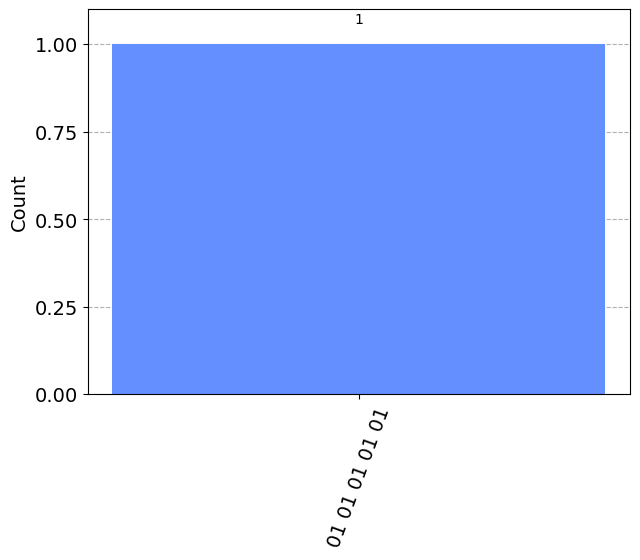

In [268]:

plot_histogram(result.get_counts(0))
# a=4
# list(range(int(a/2)))